## Problema 1: Regresión MXN vs Dólar

### 1.- Importar librerias

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

### 2.- Procesamiento de los datos

X(132, 1)
Y(132, 1)


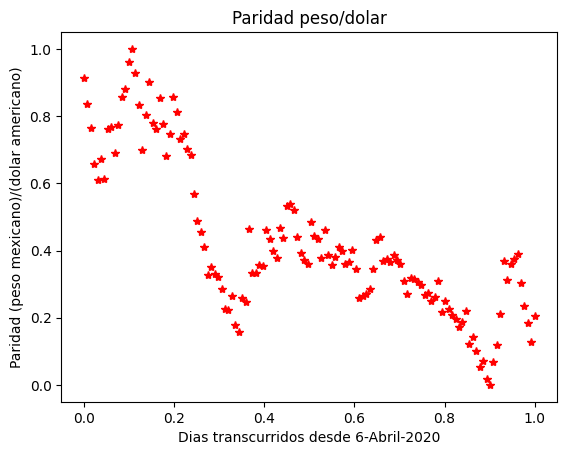

In [16]:
#Cargar datos
data = scipy.io.loadmat('datos/mxn.mat')

#Extraer valores
x = data['x']
y = data['y']

# Normalizar Y
y = (y-np.min(y))
y = y/np.max(y)

# Normalizar X
x = (x-np.min(x))
x = x/np.max(x)

# Imprimir dimensiones de los datos
print("X" + str(x.shape))
print("Y" + str(y.shape))

#Imprimir valores
plt.title("Paridad peso/dolar")
plt.xlabel("Dias transcurridos desde 6-Abril-2020")
plt.ylabel("Paridad (peso mexicano)/(dolar americano)")
plt.plot(x, y, '*', color='red');

### 3.- Definición del modelo

In [17]:
# Se propone un modelo neuronal
#       Con una capa de entrada de 3 entradas
#       Con una capa oculta de 5 neuronas
#       Con una capa de salida de 1 salida

# Se propone una función de error de medio cuadráticos
#       e = 1/2 * (Ym - Yd)^2

# Se propone Gradiete Descendiente
# wo = wo -Lr(de/dw)  --> Se aplican derivadas parciales  

#    CAPA DE SALIDA 
#    de/dw3 = de/dYm * dYm/dh3 * dh3/dw3 = (Ym - Yd) * Ym(1-Ym) * x
#    de/db3 = de/dYm * dYm/dh3 * dh3/db3 = (Ym - Yd) * Ym(1-Ym) * Y2
#    de/dY2 = de/dYm * dYm/dh3 * dh3/dY2 = (Ym - Yd) * Ym(1-Ym) * w3

#    CAPA OCULTA 
#    de/dw2 = de/dY2 * dY2/dh2 * dh2/dw2 = de/dY2 * Y2(1-Y2) * Y1
#    de/db2 = de/dY2 * dY2/dh2 * dh2/db2 = de/dY2 * Y2(1-Y2) * 1
#    de/dY1 = de/dY2 * dY2/dh2 * dh2/dY1 = de/dY2 * Ym(1-Ym) * w2

#    CAPA DE ENTRADA 
#    de/dw1 = de/dY1 * dY1/dh1 * dh1/dw1 = de/dY1 * Y1(1-Y1) * X
#    de/db1 = de/dY1 * dY1/dh1 * dh1/db1 = de/dY1 * Y1(1-Y1) * 1

In [18]:
def sigmoid(x):
    
    y = 1.0/(1.0+np.exp(-x))
    return y

# Error medio cuadrático
def emc(ym,yd):
    
    e = 0.5*np.power(ym-yd,2)
    return e

In [22]:
# Crear clase representativa de un perceptron multicapa
class mlp:
    
    # Crear constructor
    def __init__(self,ne,no,ns,d):
        
        # Capa entrada
        self.w1 = np.random.rand(ne,d)-0.5
        self.b1 = np.random.rand(ne,1)-0.5
        
        # Capa oculta
        self.w2 = np.random.rand(no,ne)-0.5
        self.b2 = np.random.rand(no,1)-0.5
        
        # Capa salida
        self.w3 = np.random.rand(ns,no)-0.5
        self.b3 = np.random.rand(ns,1)-0.5
        
    # Funcion forward (Paso hacia adelante)
    def forward(self, x):
        
        # Capa entrada
        h1 = np.dot(self.w1,x) + self.b1
        y1 = sigmoid(h1)
        
        # Capa oculta
        h2 = np.dot(self.w2,y1) + self.b2
        y2 = sigmoid(h2)
        
        # Capa salida
        h3 = np.dot(self.w3,y2) + self.b3
        ym = sigmoid(h3)
        
        return ym
    
    # Funcion de entrenamiento
    def train(self, x, y, Lr, epoch):
        
        # Inicializar el error
        self.e = np.zeros(epoch)
        
        # Lazo de epocas
        for i in range(epoch):
            
            # Lazo de datos
            for j in range(x.shape[0]):
                
                # Obtener entradas
                x_in = x[j,:].reshape([self.w1.shape[1],1])   # (d,1)
                
                # Paso hacia delante
                
                # Capa entrada                                # (ne,1)
                h1 = np.dot(self.w1,x_in) + self.b1
                y1 = sigmoid(h1)

                # Capa oculta                                 # (no,1)
                h2 = np.dot(self.w2,y1) + self.b2
                y2 = sigmoid(h2)

                # Capa salida                                 # (ns,1)
                h3 = np.dot(self.w3,y2) + self.b3
                ym = sigmoid(h3)
                
                # Calcular error del dato i
                self.e[i] = self.e[i]+emc(ym,y[j])
                
                # Calcular las gradiantes
                
                # a) GRADIENTES DEL ERROR
                de_ym = (ym-y[j])                             # (ns,1)
                
                # b) GRADIENTES DE CAPA DE SALIDA
                dym_h3 = ym*(1-ym)                            # (ns,1)
                dh3_w3 = y2                                   # (no,1)
                dh3_b3 = 1                                    # (1)
                dh3_y2 = self.w3                              # (ns,no)
                
                # c) GRADIENTES DE CAPA OCULTA
                dy2_h2 = y2*(1-y2)                            # (no,1)
                dh2_w2 = y1                                   # (ne,1)
                dh2_b2 = 1                                    # (1)
                dh2_y1 = self.w2                              # (no,ne)
                
                # d) GRADIENTES DE CAPA DE ENTRADA
                dy1_h1 = y1*(1-y1)                            # (ne,1)
                dh1_w1 = x_in                                 # (d,1)
                dh1_b1 = 1                                    # (1)
                
                # Construir gradientes
                
                # a) CAPA DE SALIDA
                de_w3 = np.dot(de_ym*dym_h3,np.transpose(dh3_w3)) # (ns,1)*(ns,1)*(no,1)=!= (ns,no)--> (ns,1)*(ns,1)x(1,no)== (ns,no)
                de_b3 = de_ym*dym_h3*dh3_b3 # (ns,1)*(ns,1)*(1)== (ns,1)    
                de_y2 = np.dot(np.transpose(de_ym*dym_h3),dh3_y2) # (ns,1)*(ns,1)*(ns,1)=!= (1,no)--> (ns,1)*(ns,1)'x(ns,no)== (1,no)
                
                # b) CAPA OCULTA
                de_w2 = np.dot(np.transpose(de_y2)*dy2_h2,np.transpose(dh2_w2)) # (1,no)*(no,1)*(ne,1)=!= (no,ne)--> (no,1)*(no,1)x(1,ne)== (no,ne)
                de_b2 = np.transpose(de_y2)*dy2_h2*dh2_b2 # (1,no)*(no,1)*(1)=!= (no,1)--> (no,1)*(no,1)*(1)== (no,1)
                de_y1 = np.dot(np.transpose(np.transpose(de_y2)*dy2_h2),dh2_y1) # (1,no)*(no,1)*(no,ne)=!= (1,ne)--> ((no,1)*(no,1))'x(no,ne)== (1,ne)
                
                # c) CAPA DE ENTRADA
                de_w1 = np.dot(np.transpose(de_y1)*dy1_h1,np.transpose(dh1_w1)) # (1,ne)*(ne,1)*(d,1)=!= (no,ne)--> (ne,1)*(ne,1)x(1,d)== (ne,d)
                de_b1 = np.transpose(de_y1)*dy1_h1*dh1_b1 # (1,ne)*(ne,1)*(1)=!= (ne,1)--> (ne,1)*(ne,1)*(1)== (ne,1)
                
                # Actualizar pesos de la red
                
                # a) CAPA DE SALIDA
                self.w3 = self.w3 - Lr*de_w3
                self.b3 = self.b3 - Lr*de_b3
                
                # b) CAPA OCULTA
                self.w2 = self.w2 - Lr*de_w2
                self.b2 = self.b2 - Lr*de_b2
                
                # a) CAPA DE ENTRADA
                self.w1 = self.w1 - Lr*de_w1
                self.b1 = self.b1 - Lr*de_b1
                
            # Promediar errod de época
            self.e[i] = self.e[i]/x.shape[0]
            

### 4.- Entrenamiento del modelo

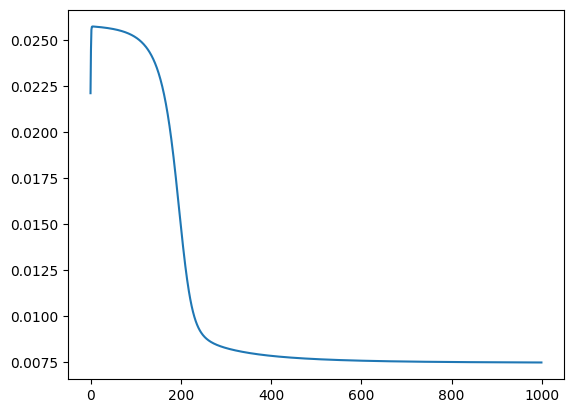

In [23]:
# Crear instancia de red neuronal
moneda = mlp(3,5,1,1) # (Entrada,Oculta,Salida,Tamaño Entrada)

# Entrenar red neuronal
moneda.train(x,y,0.1,1000)

# Imprimir curva del error
plt.figure(1)
plt.plot(moneda.e)
plt.show()

### 5.- Evaluación del modelo

Error del modelo: [0.00756672]


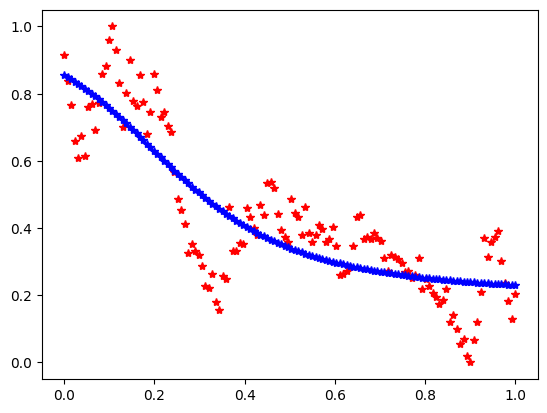

In [24]:
#Inicializar salida del modelo
ym = np.zeros(y.shape)

# Incializar error de modelo
e = 0.0

#Someter red neuronal a datos de entrada
for i in range(x.shape[0]):
    
    # Tomar dato i de vector de entradas
    x_in = x[i,:].reshape(1,1)

    # Someter entrada a red neuronal
    ym[i] = moneda.forward(x_in)
    
    # Acumular error
    e = e + emc(ym[i],y[i])

# Promediar error
e = e/x.shape[0]
print("Error del modelo: " + str(e))

#Graficar resultados
plt.plot(x, y, '*', color='red')
plt.plot(x, ym, '*', color='blue')
plt.show() 